In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

### Testing Inpainting Baselines

---

In [ ]:
from helpers.dataset import InpaintingDataset
from helpers import data_utils

from diffusers import StableDiffusionInpaintPipeline
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel

import torch

import numpy as np
from PIL import Image, ImageOps

from omegaconf import OmegaConf

In [ ]:
cfg = OmegaConf.load("../configs/train.yaml")
dataset = InpaintingDataset(cfg)
i = 6611
sample = dataset[i]
diffuse_img, partial_img, mask = sample["full_diffuse_img"], sample["partial_diffuse_img"], dataset.mask

NameError: name 'OmegaConf' is not defined

In [ ]:
def convert_mask_ndarray_to_pil(mask_np):
    # Step 1: Convert to grayscale (average RGB channels)
    if mask_np.shape[-1] == 3:
        mask_np = mask_np.mean(axis=-1)  # shape: (512, 512)

    # Step 2: Scale to [0, 255]
    mask_np = np.clip(mask_np * 255, 0, 255).astype(np.uint8)

    # Step 3: Convert to PIL image (mode 'L')
    mask_pil = Image.fromarray(mask_np, mode='L')

    return mask_pil

def convert_float_image_to_pil(img_np):
    # Step 1: Clip to [0, 1]
    img_np = np.clip(img_np, 0.0, 1.0)

    # Step 2: Scale to [0, 255]
    img_np = (img_np * 255).astype(np.uint8)

    # Step 3: Convert to PIL Image
    img_pil = Image.fromarray(img_np)

    return img_pil

def post_process_image(image):
    if type(image) == torch.Tensor:
        image = image.cpu().numpy()
    decoded_image = data_utils.channels_last(data_utils.denormalise_image(image))
    return decoded_image

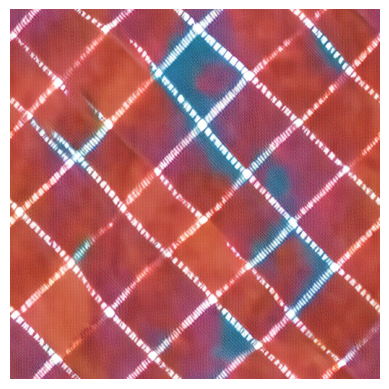

In [ ]:
target_img = post_process_image(diffuse_img)
target_img_pil = convert_float_image_to_pil(target_img)

plt.imshow(target_img_pil)
plt.axis("off")
plt.show()

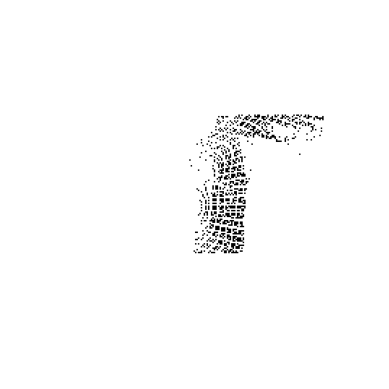

In [ ]:
mask_pil = convert_mask_ndarray_to_pil(mask)
mask_pil = ImageOps.invert(mask_pil)
plt.imshow(mask_pil, cmap="gray")
plt.axis("off")
plt.show()


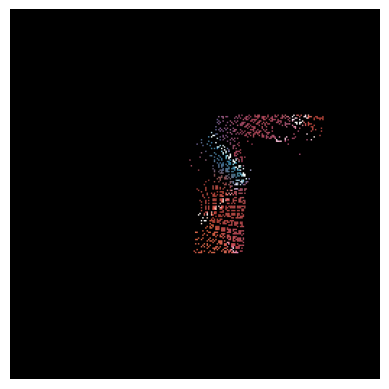

In [ ]:
img_to_inpaint = post_process_image(partial_img)
img_to_inpaint_pil = convert_float_image_to_pil(img_to_inpaint)

plt.imshow(img_to_inpaint_pil)
plt.axis("off")
plt.show()


In [ ]:
prompt = "fill the missing parts of a fabric texture matching the existing colors and style"

#### Text based only

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
 "stable-diffusion-v1-5/stable-diffusion-v1-5",   # "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16
).to("cuda")

Fetching 15 files:   7%|▋         | 1/15 [00:00<00:03,  4.31it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


In [ ]:
result = pipe(prompt=prompt, image=img_to_inpaint_pil, mask_image=mask_pil, strength=0.7).images[0]

NameError: name 'pipe' is not defined

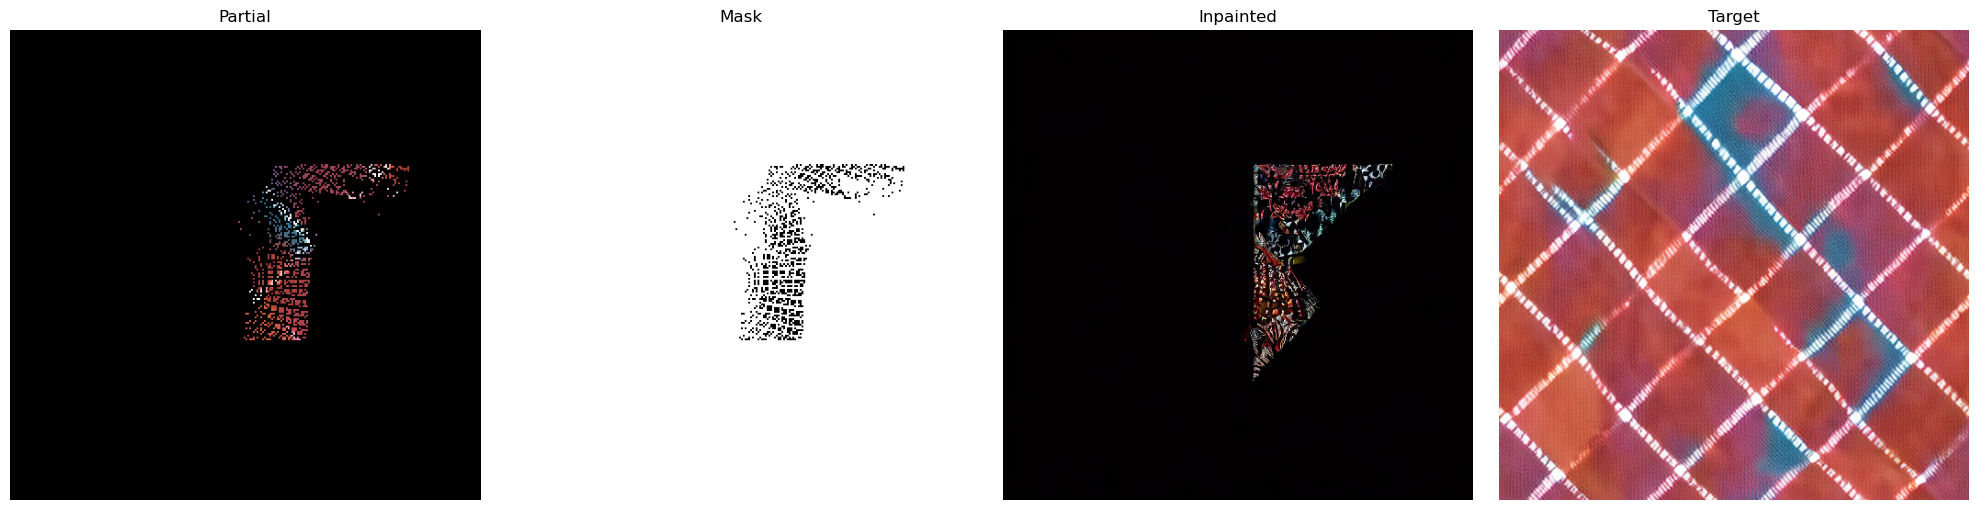

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(img_to_inpaint_pil)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask_pil, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()

#### Text+Image inpainting

In [ ]:
# Load the ControlNet model
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)

# Initialize the pipeline with ControlNet
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    controlnet=controlnet,
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]An error occurred while trying to fetch /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  57%|█████▋    | 4/7 [00:02<00:01,  1.91it/s]An error occurred while trying to fetch /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/cizinsky/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aed

In [ ]:
result = pipe(prompt=prompt, image=img_to_inpaint_pil, mask_image=mask_pil, control_image=img_to_inpaint_pil, strength=0.9).images[0]

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:03<00:00, 12.55it/s]


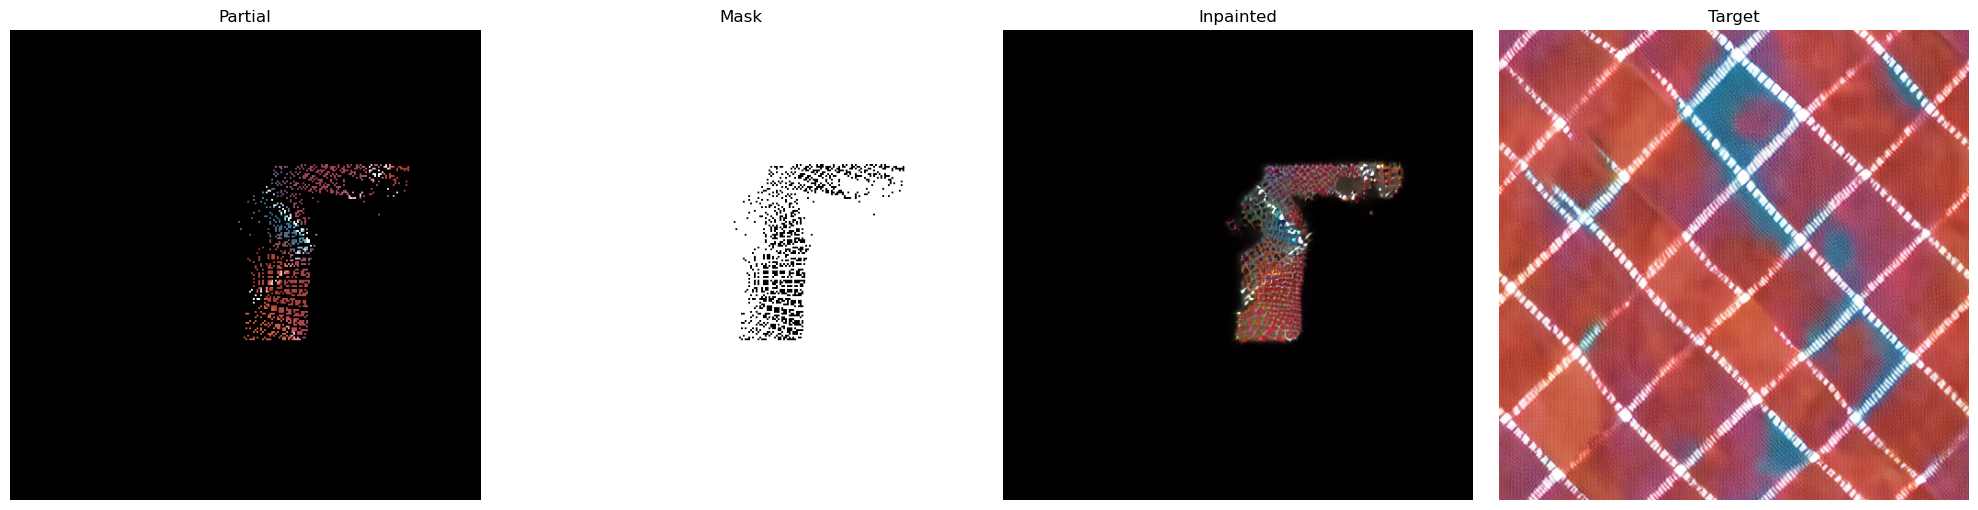

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(img_to_inpaint_pil)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask_pil, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()